In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import os
import shutil
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from typing import Literal, Optional

from rag_agent import ChatHistory

# 메모리 컨텍스트 저장 변수
stored_resume: Optional[str] = None
stored_jd: Optional[str] = None
base_chain_inputs: Optional[dict] = None
# RAG 벡터 스토어
vectorstore: Optional[Chroma] = None
# 영속 디렉토리 설정 (환경변수 또는 기본 경로)
persist_directory = os.getenv(
    "CHROMA_DB_PATH",
    os.path.join(os.getcwd(), "rag_agent/vectorstore/chroma_db")
)

chat_history = ChatHistory.get_instance()

# 로컬 파일 시스템에서 context와 회사 자료 자동 로딩
# TODO: RAG PyPDF2 -> langchain vector db
def parse_file_to_text(file_path: str) -> str:
    with open(file_path, "rb") as f:
        content = f.read()
    try:
        return content.decode("utf-8")
    except UnicodeDecodeError:
        if file_path.lower().endswith(".pdf"):
            loader = PyPDFLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        elif file_path.lower().endswith((".docx", ".doc", ".txt")):
            loader = TextLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        else:
            return content.decode("utf-8", errors="ignore")
        
def get_company_info():
    # 회사 자료 검색
    retrieved = vectorstore.similarity_search(stored_jd, k=3)
    company_info = "\n".join([doc.page_content for doc in retrieved])
    # Trim company_info to avoid exceeding model context window
    max_company_info_length = 2000
    if len(company_info) > max_company_info_length:
        company_info = company_info[:max_company_info_length]
    return company_info


base_dir = os.path.join(os.getcwd(), "data")
# 이력서 로딩
resume_dir = os.path.join(base_dir, "resume")
for fname in os.listdir(resume_dir):
    stored_resume = parse_file_to_text(os.path.join(resume_dir, fname))
    break
# JD 로딩
jd_dir = os.path.join(base_dir, "jd")
for fname in os.listdir(jd_dir):
    stored_jd = parse_file_to_text(os.path.join(jd_dir, fname))
    break
# 회사 자료 로딩 및 인덱싱
company_dir = os.path.join(base_dir, "company_infos")
docs = []
for fname in os.listdir(company_dir):
    text = parse_file_to_text(os.path.join(company_dir, fname))
    splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    for chunk in splitter.split_text(text):
        docs.append(Document(page_content=chunk, metadata={"filename": fname}))
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(
    persist_directory=persist_directory, embedding_function=embeddings
)
stored_company_info = get_company_info()
base_chain_inputs = {
    "resume": stored_resume,
    "jd": stored_jd,
    "company_infos": stored_company_info,
}
if docs:
    texts = [d.page_content for d in docs]
    metadatas = [d.metadata for d in docs]
    vectorstore.add_texts(texts=texts, metadatas=metadatas)
    vectorstore.persist()

ModuleNotFoundError: No module named 'langchain_community'

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from rag_agent import ChatHistory

class AgentState(TypedDict):
    query: str # 사용자 답변
    answer: str # Agent 답변
    input_type: str # 사용자 답변 유형
    persona_id: str # 페르소나 ID
    route_type: str # routing 결과
    resume: str # 자소서(이력서)
    jd: str # 채용공고
    company: str # 회사정보 (인재상)
    chat_history: ChatHistory # 대화내역
    last_question: str #마지막 질문        

In [ ]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

import os

llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"), temperature=0.7, model_name="gpt-4o-mini"
)


In [ ]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate

def classify_input(state: AgentState) -> AgentState:
    """
    사용자 입력을 바탕으로 현재 입력이 어떤 형식인지 분류하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (AgentState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    query = state.get("query", "")
    print("classify_input > query >", query)
    
    classify_prompt = PromptTemplate.from_template("""
주어진 query와 chat_history를 바탕으로 입력이이 어떤 유형인지 판단하세요: 
- 면접질문 요청 (question)
- 꼬리질문 요청 (followup)
- 모범답변 요청 (modelAnswer)
- 답변 (answer)
- 그 외 면접과 관련 없는 텍스트 (other)


사용자 입력:
{query}

형식: question, followup, modelAnswer, answer, other 중 하나로만 답하세요.
""")
    
    router_chain = classify_prompt | llm | StrOutputParser() 
    result = router_chain.invoke({'query': query})
    
    print("classify_input", result)
    # # 분류 결과 추출 (마지막 메시지의 content가 분류값)
    # classification = result['messages'][-1].content.strip()
    
    # 결과 메시지를 업데이트하고 router node로 이동합니다.
    return { 
        "input_type": result
    }

In [ ]:
from rag_agent import PersonaService
from rag_agent.persona.Persona import Persona, PersonaType
from rag_agent.persona.PersonaService import PersonaInput

persona_service = PersonaService.get_instance()
# persona_service.set_context(stored_resume, stored_jd)
# 페르소나 추가 (테스트용)
persona_service.add_persona(
    PersonaInput(
        name="Recruiter",
        type="other",
        interests=["조직 적응력", "인성"],
        communicationStyle="차분하고 상냥한 스타일",
    )
)
persona_service.add_persona(
    PersonaInput(
        name="CTO",
        type="developer",
        interests=["이슈 해결 과정과 Lessons Learned"],
        communicationStyle="불필요한 말은 하지 않음, 합리적이고 이성적인 스타일",
    )
)

def assign_persona_node(state: AgentState) -> AgentState:
    """
    페르소나 할당 node입니다. 주어진 state를 기반으로 assign_persona 에이전트를 호출하고,
    결과를 router node로 전달합니다.

    Args:
        state (AgentState): 현재 메시지 상태 객체.

    Returns:
        Command: router node로 이동 명령을 반환.
    """
    print(state)
    resume = state.get("resume", "")
    jd = state.get("jd", "")
    company = state.get("company", "")
    query = state.get("query", "")
    last_question = state.get("last_question", "")
    persona_id = persona_service.invoke_agent(resume, jd, company, query, last_question)
    print("assign_persona_node", persona_id)
    
    return { "persona_id": persona_id }
    

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['generate_question', 'generate_model_answer', 'generate_followup', 'llm'] = Field(
        description="The target for the query to answer"
    )

def router(state: AgentState) -> AgentState:
    """
    주어진 state에서 input_type를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['question', 'model_answer', 'followup', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    
    router_system_prompt = """
You are an expert at routing a user's input type to 'question', 'model_answer', 'followup' or 'llm'.
If the user input is 'question' route to 'question'.

'question' contains information about resume, company, jd.
'model_answer' contains information about last question and context(company, resume, jd).
'followup' contains information about last question and applicant's answer.
if you think the question is not related to either 'question', 'model_answer' or 'followup';
you can route it to 'llm'."""
    
    router_prompt = ChatPromptTemplate.from_messages([
        ('system', router_system_prompt),
        ('user', '{query}')
    ])

    structured_router_llm = llm.with_structured_output(Route)

    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})
    print("router", route)

    return { "route_type": route }



In [ ]:
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

def generation(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 면접 질문을 생성하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
                
        generation_prompt = PromptTemplate.from_template(
            """다음은 지원자의 자소서, JD(직무기술서), 회사 정보, 그리고 면접관 페르소나입니다:

            자기소개서:
            {resume}

            JD:
            {jd}

            회사 정보:
            {company}

            면접관 페르소나:
            {persona}

            당신은 위 페르소나를 기반으로 하는 면접관입니다.
            다음 단계를 거쳐 면접 질문을 생성하세요:

            1단계 - 분석 (Reasoning):
            - 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
            - JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
            - 부족하거나 확인이 필요한 부분은 무엇인가?
            - 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

            2단계 - 질문 생성 (Acting):
            - 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
            - 면접관 페르소나의 말투와 스타일을 반영

            출력 형식:
            [2단계에서 생성된 면접 질문]
            """
        )

        chain = generation_prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume, 
            "jd": jd, 
            "company": company, 
            "persona": persona
        })
        print("result", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Generation 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [ ]:
# from langchain.prompts import PromptTemplate, ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
# from langchain_core.tools import tool

# import json

# class AssessmentResult(BaseModel):
#     logicScore: int
#     jobFitScore: int
#     coreValueFitScore: int
#     communicationScore: int
#     averageScore: float

# def evaluate_answer(state: AgentState) -> AgentState:
#     """
#     이전 대화내용을 기반으로 사용자 입력을 평가하고
#     결과를 router node로 전달합니다.
    
#     Args:
#       state (AgentState): 현재 메시지 상태를 나타내는 객체입니다.
    
#     Returns:
#       Command: router node로 이동하기 위한 명령을 반환합니다.
#     """

#     parser = JsonOutputParser(pydantic_object=AssessmentResult)
    
#     # 상태에서 필요한 정보 추출
#     resume = state.get("resume", "")
#     jd = state.get("jd", "")
#     company = state.get("company", "")
#     persona = state.get("persona", "")
#     last_question = state.get("last_question", "")
        
#     assessment_prompt = PromptTemplate(
#         input_variables=["resume", "jd", "company", "last_question", "answer", "persona"],
#         template="""
#         역할: 면접관으로서 지원자의 답변을 평가합니다.

#         직무 설명:
#         {jd}

#         이력서:
#         {resume}

#         회사 정보:
#         {company}

#         질문: 
#         {last_question}
        
#         지원자의 답변:
#         {answer}

#         면접관 정보:
#         {persona}
        
#         다음 4개 항목을 0-10점으로 평가하세요:
#         1. 논리성 (logicScore): 답변의 논리적 일관성과 구조
#         2. 직무적합성 (jobFitScore): JD 요구사항과의 부합도
#         3. 핵심가치 부합성 (coreValueFitScore): 회사 가치와의 일치도
#         4. 커뮤니케이션 능력 (communicationScore): 의사소통 명확성

#         {format_instructions}
#         """,
#         partial_variables={"format_instructions": parser.get_format_instructions()}
#     )

#     chain = assessment_prompt | llm | parser
    
#     try:
#         result = chain.invoke({
#             "jd": jd,
#             "resume": resume,
#             "company": company,
#             "question": question,
#             "answer": answer,
#             "persona": persona,
#         })
#         return result
#     except Exception as e:
#         return {"error": "평가 중 오류가 발생했습니다."}

In [ ]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

def followup(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 현재 입력에 대한 꼬리질문을 생성하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
        chat_history = state.get("chat_history", "")
        query = state.get("query", "")
                
        followup_prompt = PromptTemplate.from_template(
            """아래는 AI 면접 시스템에서 지금까지 진행된 대화입니다:

대화 이력:
{chat_history}

현재 질문에 대한 지원자의 답변:
{query}

자기소개서:
{resume}

JD:
{jd}

회사 정보:
{company}

면접관 페르소나:
{persona}

당신은 위 페르소나를 기반으로 하는 면접관입니다.
다음 단계를 거쳐 면접 질문을 생성하세요:

1단계 - 분석 (Reasoning):
- 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
- JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
- 부족하거나 확인이 필요한 부분은 무엇인가?
- 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

2단계 - 질문 생성 (Follow-up Question):
- 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
- 면접관 페르소나의 말투와 스타일을 반영

출력 형식:
[생성된 꼬리 면접 질문]
"""
        )

        chain = followup_prompt | llm | StrOutputParser()
        result = chain.invoke({
            "resume": resume, 
            "jd": jd, 
            "company": company, 
            "persona": persona,
            "chat_history": chat_history,
            "query": query,
        })
        print("result", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Followup 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [ ]:
def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    query = state['query']
    llm_chain = llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer }

In [ ]:
def conditional_router(state: AgentState) -> str:
    """
    그래프의 조건부 엣지에서 사용할 라우팅 함수
    
    Args:
        state (AgentState): 현재 상태
        
    Returns:
        str: 다음 노드 이름
    """
    # 상태에서 라우팅 정보 확인
    print(state)
    next_route = state.get('next_route', 'other')
    
    # 그래프 노드 이름과 매핑
    route_mapping = {
        'generation': 'generation',
        'question': 'generation',
        'answer': 'generation',
        'followup': 'followup',
        'model_answer': 'ModelAnswer', 
        'interview_answer': 'EvaluateFollowup',
        'other': 'generation'
    }
    
    return route_mapping.get(next_route, 'generation')

In [ ]:

from langgraph.graph import START, END
    
graph_builder = StateGraph(AgentState)

# 노드 추가
graph_builder.add_node('classify_input', classify_input)
graph_builder.add_node('assign_persona', assign_persona_node)
graph_builder.add_node('router', router)
graph_builder.add_node('generation', generation)
graph_builder.add_node('followup', followup)
graph_builder.add_node('llm', call_llm)

# 시작점에서 병렬 실행
graph_builder.add_edge(START, 'classify_input')
graph_builder.add_edge(START, 'assign_persona')

# 두 병렬 노드가 완료되면 라우터로
graph_builder.add_edge('classify_input', 'router')
graph_builder.add_edge('assign_persona', 'router')

# 생성 노드에서 종료
graph_builder.add_edge('generation', END)
graph_builder.add_edge('followup', END)
graph_builder.add_edge('llm', END)

graph_builder.add_conditional_edges(
    'router',
    conditional_router,
    {
        "generation": "generation",
        "followup": "followup",
        "llm": "llm"
    }
)

In [ ]:
graph = graph_builder.compile()

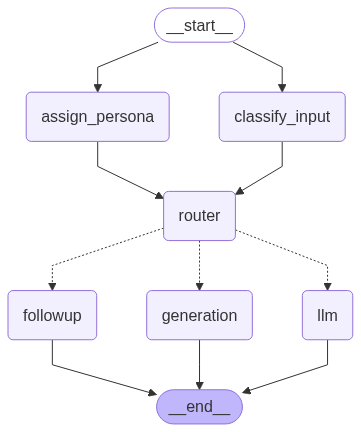

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = { 
    "query": "떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘", 
    "resume": stored_resume, 
    "jd": stored_jd,
    "company": stored_company_info,
    "chat_history": chat_history.get_all_history_as_string(),
    "last_question": chat_history.get_question_by_id(
        chat_history.get_latest_question_id()
    ) 
}
graph.invoke(initial_state)


{'query': '떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘', 'resume': '# 토스 Python Developer 지원서\r\n\r\n## 📋 이력서\r\n\r\n### 경력 사항\r\n\r\n#### Python Backend Developer | 네이버 (2022.03 - 현재)\r\n\r\n**주요 성과:**\r\n- **복잡도 높은 Django 기반 시스템 구축**\r\n  - 월 100만+ 사용자 대상 전자상거래 플랫폼 백엔드 개발\r\n  - Django REST Framework를 활용한 RESTful API 설계 및 구현 (30+ endpoints)\r\n  - 복잡한 비즈니스 로직 처리를 위한 모델 설계 및 최적화 수행\r\n\r\n- **데이터 모델링 및 API 설계**\r\n  - 주문/결제/배송 시스템의 데이터베이스 스키마 설계 (20+ 테이블)\r\n  - 성능 최적화를 위한 인덱싱 및 쿼리 튜닝으로 응답시간 40% 개선\r\n  - GraphQL과 REST API 혼합 아키텍처 설계로 프론트엔드 개발 효율성 향상\r\n\r\n- **비즈니스 문제 해결**\r\n  - 수동 재고 관리 프로세스 자동화로 업무 시간 80% 단축\r\n  - Redis 캐싱 전략 도입으로 데이터베이스 부하 60% 감소\r\n  - Celery를 활용한 비동기 작업 처리로 사용자 경험 개선\r\n\r\n**기술 스택:**\r\n- Backend: Python, Django, Django REST Framework\r\n- Database: PostgreSQL, Redis\r\n- Message Queue: Celery, RabbitMQ\r\n- Infrastructure: Docker, AWS ECS, RDS\r\n- Monitoring: Sentry, CloudWatch\r\n\r\n#### Junior Python Developer | 쿠팡 (2021.01 - 2022.02)\r\n\r\n**주요 업무:**\r\n- Django 기반 사내 업

22:58:59 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


classify_input other


22:59:02 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


assign_persona_node Thought: The applicant is a Python Developer with a strong background in Django development and a keen interest in solving business problems with technology. The job description requires someone who can work on internal systems, automate processes, and build scalable frameworks, which aligns well with the applicant's experience and goals. The CTO persona is focused on issue resolution and lessons learned, which matches the applicant's approach to problem-solving and technical growth. The applicant's communication style and experience suggest a fit with the CTO persona, which is rational and efficient in communication.

Final Answer: c26cf481


22:59:03 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


router target='llm'
{'query': '떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘', 'input_type': 'other', 'persona_id': "Thought: The applicant is a Python Developer with a strong background in Django development and a keen interest in solving business problems with technology. The job description requires someone who can work on internal systems, automate processes, and build scalable frameworks, which aligns well with the applicant's experience and goals. The CTO persona is focused on issue resolution and lessons learned, which matches the applicant's approach to problem-solving and technical growth. The applicant's communication style and experience suggest a fit with the CTO persona, which is rational and efficient in communication.\n\nFinal Answer: c26cf481", 'route_type': 'question', 'resume': '# 토스 Python Developer 지원서\r\n\r\n## 📋 이력서\r\n\r\n### 경력 사항\r\n\r\n#### Python Backend Developer | 네이버 (2022.03 - 현재)\r\n\r\n**주요 성과:**\r\n- **복잡도 높은 Django 기반 시스템 구축**\r\n  - 월 100만+ 사용자 대상 전자상거래 플랫폼 백엔드 개발\r\n  

22:59:11 [INFO] httpx: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


result ### 1단계 - 분석 (Reasoning):
- **회사 인재상에 부합하는 성격/역량/행동 확인**: 지원자는 기술적 문제 해결 능력과 비즈니스 가치 창출을 강조하며, 조직 문화에 대한 깊은 이해를 바탕으로 팀의 생산성 향상에 기여하고자 하는 의지를 보이고 있습니다. 이는 토스의 "고객 중심" 문화 및 팀워크를 중시하는 가치에 부합합니다. 지원자는 지속적인 소통과 협업을 통해 문제를 해결하고, 기술적 설계를 통해 팀원들이 더 가치 있는 일에 집중할 수 있도록 돕는 모습이 인상적입니다.

- **JD와 자소서의 부합성**: JD에서 요구하는 Python, Django 경험 및 데이터 모델링, API 설계 능력 등은 자소서에서 잘 드러나 있습니다. 특히, 복잡한 Django 기반 시스템 구축 및 RESTful API 설계 경험이 잘 맞아떨어집니다. 또한, 지원자는 자동화와 효율성 향상을 위한 경험을 강조하며, 이는 JD에서 언급된 업무와 매우 일치합니다.

- **부족하거나 확인이 필요한 부분**: 지원자는 다양한 비즈니스 문제 해결 경험을 기술했지만, 특정 기술 스택에 대한 깊이 있는 경험(예: Kubernetes, GoCD 등)이나 보안 요건 충족 경험에 대한 언급이 부족합니다. 이는 토스의 보안 요구 사항을 충족하기 위해 중요한 요소일 수 있습니다.

- **면접관 페르소나의 시각과 말투**: 면접관은 지원자의 경험과 가치관에 대해 진솔한 대화를 나누기를 원합니다. 따라서 질문은 지원자의 기술적 경험뿐만 아니라 조직 문화에 대한 이해도를 평가하는 방향으로 설정해야 합니다.

### 2단계 - 질문 생성 (Acting):
"안녕하세요, 지원자님. 자소서에서 '기술적 이상보다는 비즈니스 가치 창출이 우선되어야 한다'고 말씀하셨는데요, 구체적으로 어떤 사례를 통해 이 가치를 실현하셨는지, 그리고 그 과정에서 팀원들과 어떤 방식으로 소통하며 협업하셨는지 들려주실 수 있을까요?"


{'query': '떡볶이 먹고싶다 서울 떡볶이 맛집 좀 알려줘줘',
 'answer': '### 1단계 - 분석 (Reasoning):\n- **회사 인재상에 부합하는 성격/역량/행동 확인**: 지원자는 기술적 문제 해결 능력과 비즈니스 가치 창출을 강조하며, 조직 문화에 대한 깊은 이해를 바탕으로 팀의 생산성 향상에 기여하고자 하는 의지를 보이고 있습니다. 이는 토스의 "고객 중심" 문화 및 팀워크를 중시하는 가치에 부합합니다. 지원자는 지속적인 소통과 협업을 통해 문제를 해결하고, 기술적 설계를 통해 팀원들이 더 가치 있는 일에 집중할 수 있도록 돕는 모습이 인상적입니다.\n\n- **JD와 자소서의 부합성**: JD에서 요구하는 Python, Django 경험 및 데이터 모델링, API 설계 능력 등은 자소서에서 잘 드러나 있습니다. 특히, 복잡한 Django 기반 시스템 구축 및 RESTful API 설계 경험이 잘 맞아떨어집니다. 또한, 지원자는 자동화와 효율성 향상을 위한 경험을 강조하며, 이는 JD에서 언급된 업무와 매우 일치합니다.\n\n- **부족하거나 확인이 필요한 부분**: 지원자는 다양한 비즈니스 문제 해결 경험을 기술했지만, 특정 기술 스택에 대한 깊이 있는 경험(예: Kubernetes, GoCD 등)이나 보안 요건 충족 경험에 대한 언급이 부족합니다. 이는 토스의 보안 요구 사항을 충족하기 위해 중요한 요소일 수 있습니다.\n\n- **면접관 페르소나의 시각과 말투**: 면접관은 지원자의 경험과 가치관에 대해 진솔한 대화를 나누기를 원합니다. 따라서 질문은 지원자의 기술적 경험뿐만 아니라 조직 문화에 대한 이해도를 평가하는 방향으로 설정해야 합니다.\n\n### 2단계 - 질문 생성 (Acting):\n"안녕하세요, 지원자님. 자소서에서 \'기술적 이상보다는 비즈니스 가치 창출이 우선되어야 한다\'고 말씀하셨는데요, 구체적으로 어떤 사례를 통해 이 가치를 실현하셨는지, 그리고 그 과정에서 팀원들과 어떤 방식으로 소통하며 협업하셨는지